In [32]:
import numpy as np 
import pandas as pd
import os
import PIL
from PIL import Image
import cv2
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
xTrain=[]
yTrain=[]
for dirname, _, filenames in os.walk('/content/drive/MyDrive/skinLesion/training/ISIC-2017_Training_Data'):
        xTrain= np.array([np.array(Image.open(os.path.join(dirname, filename)))for filename in sorted(filenames)])

for dirname, _, filenames in os.walk('/content/drive/MyDrive/skinLesion/training/ISIC-2017_Training_Part1_GroundTruth'):
        yTrain= np.array([np.array(Image.open(os.path.join(dirname, filename)))for filename in sorted(filenames)])
               

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


In [55]:
xValid=[]
yValid=[]
for dirname, _, filenames in os.walk('/content/drive/MyDrive/skinLesion/validation/ISIC-2017_Validation_Data'):
        xValid= np.array([np.array(Image.open(os.path.join(dirname, filename)))for filename in sorted(filenames)])

for dirname, _, filenames in os.walk('/content/drive/MyDrive/skinLesion/validation/ISIC-2017_Validation_Part1_GroundTruth'):
        yValid= np.array([np.array(Image.open(os.path.join(dirname, filename)))for filename in sorted(filenames)])
               

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


In [56]:
xTest=[]
yTest=[]
for dirname, _, filenames in os.walk('/content/drive/MyDrive/skinLesion/test/ISIC-2017_Test_v2_Data'):
        xTest= np.array([np.array(Image.open(os.path.join(dirname, filename)))for filename in sorted(filenames)])

for dirname, _, filenames in os.walk('/content/drive/MyDrive/skinLesion/test/ISIC-2017_Test_v2_Part1_GroundTruth'):
        yTest= np.array([np.array(Image.open(os.path.join(dirname, filename)))for filename in sorted(filenames)])
               

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


In [57]:
xTrain.shape

(2000,)

In [58]:
xValid.shape

(150,)

In [59]:
xTest.shape

(600,)

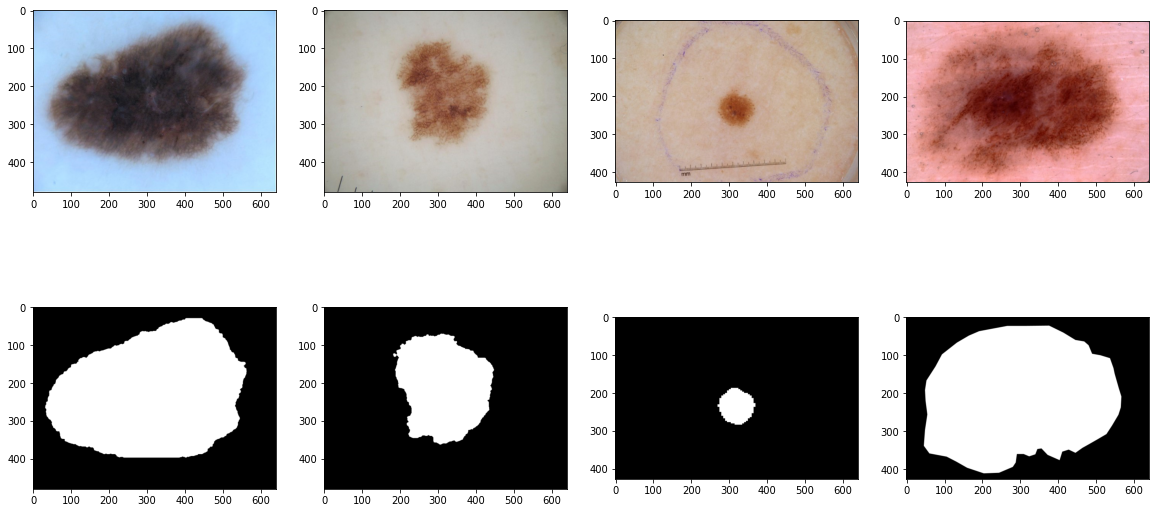

In [53]:
plt.figure(figsize=(20,10))
plt.subplot(2,4,1)
plt.imshow(xTrain[0])
plt.subplot(2,4,2)
plt.imshow(xTrain[600])
plt.subplot(2,4,3)
plt.imshow(xTrain[1200])
plt.subplot(2,4,4)
plt.imshow(xTrain[1900])
plt.subplot(2,4,5)
plt.imshow(yTrain[0],cmap = plt.cm.binary_r)
plt.subplot(2,4,6)
plt.imshow(yTrain[600],cmap = plt.cm.binary_r)
plt.subplot(2,4,7)
plt.imshow(yTrain[1200],cmap = plt.cm.binary_r)
plt.subplot(2,4,8)
plt.imshow(yTrain[1900],cmap = plt.cm.binary_r)